In [1]:
# NEED TO INSTALL THE FOLLOWING WITH PIP FIRST:

"""
wrds,
swig,
finrl==0.3.5
elegantrl==0.3.3
git+https://github.com/AI4Finance-Foundation/FinRL.git
"""

'\n## install finrl library\n!pip install wrds\n!pip install swig\n!pip install finrl==0.3.5\n\n## instal elegantrl\n# !pip install elegantrl==0.3.3\n\n!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git\n'

In [2]:


from stable_baselines3.common.logger import configure


import sys
sys.path.append("../FinRL")



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [5]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

tickers_list = ['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']

df = YahooDownloader(start_date = '2012-01-01',
                     end_date = '2023-10-31',
                     ticker_list = tickers_list).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (14880, 8)


In [6]:
print(tickers_list)

['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']


In [7]:
df.shape

(14880, 8)

In [141]:
# df.sort_values(['date','tic'],ignore_index=True).head()
df.sort_values(['date'],ignore_index=True)

,date,open,high,low,close,volume,tic,day
0,2012-01-03,14.621429,14.732143,14.607143,12.449689,302220800,AAPL,1
1,2012-01-03,92.769997,95.110001,92.769997,67.953003,8177000,CAT,1
2,2012-01-03,18.549999,18.860001,18.480000,12.924058,41236600,CSCO,1
3,2012-01-03,26.549999,26.959999,26.389999,21.278032,64731500,MSFT,1
4,2012-01-03,24.342501,24.497499,24.174999,21.074886,10944400,NKE,1
...,...,...,...,...,...,...,...,...
14875,2023-10-30,333.410004,339.450012,331.829987,336.626770,22828100,MSFT,0
14876,2023-10-30,169.020004,171.169998,168.869995,170.065933,51131000,AAPL,0
14877,2023-10-30,240.940002,243.600006,239.179993,242.160004,4478300,CAT,0
14878,2023-10-30,51.349998,51.639999,51.090000,51.171814,13322400,CSCO,0


In [9]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split


feature_engineer = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False)

states_df = feature_engineer.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2975, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
from itertools import product
import pandas as pd
dates = list(pd.date_range(states_df['date'].min(),states_df['date'].max()).astype(str))

preprocessed_df = pd.DataFrame(list(product(dates,tickers_list)),columns=["date","tic"])
preprocessed_df = preprocessed_df.merge(states_df,how="left",on=["date","tic"],)
preprocessed_df = preprocessed_df[preprocessed_df['date'].isin(states_df['date'])]
preprocessed_df = preprocessed_df.sort_values(['date','tic'])

preprocessed_df = preprocessed_df.fillna(0)



In [11]:
preprocessed_df.describe()

,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
count,14875.000000,14875.000000,14875.000000,14875.000000,1.487500e+04,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,87.925341,88.823777,87.011258,81.711926,5.318533e+07,2.024874,0.364079,85.793759,76.633687,53.993698,25.419957,24.035344,80.960192,80.175403,17.832192,5.082796
std,69.802263,70.572683,68.999996,69.519045,1.044569e+08,1.398985,1.978481,73.222779,65.009080,9.108032,112.768150,17.081371,68.799795,68.013646,6.851859,9.983662
min,13.856071,14.271429,13.753571,10.578132,5.857000e+05,0.000000,-9.607839,11.796429,10.061002,25.806161,-519.458107,0.002358,11.423214,11.510131,9.140000,0.000000
25%,35.806250,36.121250,35.495001,31.222950,6.484750e+06,1.000000,-0.265390,32.151753,29.122308,47.574028,-60.106072,10.040956,30.320554,29.099533,13.370000,1.100484
50%,58.730000,59.349998,58.250000,54.248795,1.986530e+07,2.000000,0.231522,56.488090,51.163763,53.864373,43.016073,21.417965,53.548150,53.097536,16.070000,2.442872
75%,123.434998,124.844997,121.505001,116.092136,4.488855e+07,3.000000,0.905560,123.432461,105.970707,59.981754,108.892142,35.287715,114.693447,114.526896,20.549999,5.185709
max,361.750000,366.779999,352.440002,358.003845,1.506120e+09,4.000000,13.481134,358.153223,327.322526,100.000000,666.478672,100.000000,338.987468,332.702074,82.690002,137.878037


In [12]:
train = data_split(preprocessed_df, '2012-01-01','2020-07-01')
test = data_split(preprocessed_df, '2020-07-01','2023-10-31')


In [15]:
stock_size = len(tickers_list)
state_space = 1 + 2*stock_size + len(['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'])*stock_size

# 8 indictor/price features PER stock (there's 5 here)
# Plus, the raw price data is captured again as 2 extra features per stock (typically Open and Close price).
# So + 2N state variables
# Hence 8*5 (indicators) + 2*5 (raw price) + 1 (offset variable)

stock_size, state_space

(5, 51)

In [16]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv


training_environment, initial_observations = StockTradingEnv(df = train, hmax= 100,
    initial_amount= 1000000, # STARTING AMOUNT HERE
    num_stock_shares= [0] * stock_size,
    buy_cost_pct= [.1/100] * stock_size, # Transaction fee percent of buys per stock
    sell_cost_pct= [.1/100] * stock_size,
    state_space= state_space,
    stock_dim= stock_size, # Stock dimensions
    tech_indicator_list= ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    action_space= stock_size, 
    reward_scaling= 1e-4).get_sb_env() 
# creates a vectorized environment compatible with Stable Baselines algorithms
# uses DummyVecEnv from Stable Baselines to create a vectorized wrapper of the trading env
# wraps the env in a Vectorized environment that handles all the multiprocessing - steps, resets etc.
# It calls reset() on the vectorized env to get the initial observations
"""
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.
"""


"\nThe training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.\n\nOur market environment, based on OpenAI Gym, simulates stock markets with historical market data.\n"

In [ ]:
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_baseline


In [23]:

"""
# Automatically build models from list of model names
agent = DRLAgent(training_environment)
models=[]
def log_model(model_name):
    print(model_name)
    model = agent.get_model(f"{model_name}")
    model.set_logger(configure(RESULTS_DIR + f'/{model_name}', ["stdout", "csv", "tensorboard"]))
    models.append((model_name, model))

model_names=['a2c'
            ,'ddpg'
            # ,'ppo'
            # ,'sac'
            ]
for model_name in model_names:
    log_model(model_name)
print(models)

"""

a2c
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
ddpg
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg
[('a2c', <stable_baselines3.a2c.a2c.A2C object at 0x00000277B99490C0>), ('ddpg', <stable_baselines3.ddpg.ddpg.DDPG object at 0x00000277B99490F0>)]


In [148]:
a2c_params = {
    "n_steps": 5,
    "ent_coef": 0.01,
    "learning_rate": 7e-4,
    "gamma": 0.99,
    "gae_lambda": 0.95
}
a2c_tuned_params = {
    "n_steps": 1,
    "ent_coef": 0.0755882482216129,
    "learning_rate": 2.637065887731285e-05,
    "gamma": 0.9048260592925886,
    "gae_lambda": 0.9717236074963396
}

agent = DRLAgent(training_environment)
a2c_model = agent.get_model("a2c", model_kwargs=a2c_tuned_params)
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
a2c_model.set_logger(new_logger_a2c)
trained_a2c = DRLAgent(training_environment).train_model(model=a2c_model,
                             tb_log_name='a2c',
                             total_timesteps=50000) 


# A2C HYPERPARAMS MOST IMPORTANT
# learning_rate: The learning rate determines how quickly the model learns from new experiences. This is one of the most important to get right. Too small and it will learn slowly. Too large and it may have issues converging.
# n_steps: The number of steps collected before each update. More steps allows more efficient batch updates but delays learning from recent experiences. Finding a good balance is important.
# gamma: The discount factor determines how much the agent values future rewards. Higher values make it value long-term rewards more.
# gae_lambda: The GAE lambda controls the bias-variance tradeoff for estimating returns. Values closer to 1 have lower variance but higher bias.
# ent_coef: The entropy coefficient controls how much the agent is encouraged to explore randomly. Higher values result in more random actions.
# max_grad_norm: Gradient clipping limit to improve stability. You generally don't need to tune this much.


{'n_steps': 1, 'ent_coef': 0.0755882482216129, 'learning_rate': 2.637065887731285e-05, 'gamma': 0.9048260592925886, 'gae_lambda': 0.9717236074963396}
Using cpu device
Logging to results/a2c
---------------------------------------
| time/                 |             |
|    fps                | 137         |
|    iterations         | 100         |
|    time_elapsed       | 0           |
|    total_timesteps    | 100         |
| train/                |             |
|    entropy_loss       | -7.11       |
|    explained_variance | nan         |
|    learning_rate      | 2.64e-05    |
|    n_updates          | 99          |
|    policy_loss        | -0.904      |
|    reward             | -0.13941592 |
|    std                | 1           |
|    value_loss         | 0.00852     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 155         |
|    iterations         | 200         |
|    time_

In [149]:
agent = DRLAgent(env = training_environment)
ppo_params = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

ppo_tuned_params = {
    "n_steps": 232,
    "ent_coef": 0.08005421293955037,
    "learning_rate": 0.0002058992300570136,
    "batch_size": 238


}
model_ppo = agent.get_model("ppo",model_kwargs = ppo_tuned_params)

# set up logger
new_logger_ppo = configure(RESULTS_DIR + '/ppo', ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

# DDPG HYPERPARAMS MOST IMPORTANT
# learning_rate: Determines how quickly the model learns from new data. Too low may learn slowly, too high can destabilize training.
# buffer_size: The size of the replay buffer holding experiences. Larger buffers allow longer term learning but cost memory.
# batch_size: The size of sampled batch from the replay buffer for learning updates. Too small may underutilize GPU/CPU resources.
# tau: Controls weighting between older and newer Q-network weights during update. Controls stability vs plasticity.
# train_freq: How frequently the model trains. Balance between learning from more data vs more frequent updates.
# gradient_steps: Number of gradient steps during each training update. More may increase stability.


{'n_steps': 232, 'ent_coef': 0.08005421293955037, 'learning_rate': 0.0002058992300570136, 'batch_size': 238}
Using cpu device
Logging to results/ppo


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning:

You have specified a mini-batch size of 238, but because the `RolloutBuffer` is of size `n_steps * n_envs = 232`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 232
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=232 and n_envs=1)



-------------------------------------
| time/              |              |
|    fps             | 495          |
|    iterations      | 1            |
|    time_elapsed    | 0            |
|    total_timesteps | 232          |
| train/             |              |
|    reward          | -0.035142787 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 484          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 464          |
| train/                  |              |
|    approx_kl            | 0.0062470096 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.1         |
|    explained_variance   | 0            |
|    learning_rate        | 0.000206     |
|    loss                 | -0.566       |
|    n_updates            | 10           |
|    policy_g

-----------------------------------------
| time/                   |             |
|    fps                  | 556         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008732445 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00872    |
|    reward               | -8.01567    |
|    std                  | 1           |
|    value_loss           | 33          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 519          |
|    iterations           | 2  

In [74]:
data_risk_indicator = preprocessed_df[(preprocessed_df.date<'2020-07-01') & (preprocessed_df.date>='2012-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date']) # INCLUDES THE VIX AND TURBULENCE INDICATORS ALONGSIDE WITH PREV TECHNICAL INDICATORS

for col in insample_risk_indicator: 
    print(col)

date
tic
open
high
low
close
volume
day
macd
boll_ub
boll_lb
rsi_30
cci_30
dx_30
close_30_sma
close_60_sma
vix
turbulence


In [29]:
insample_risk_indicator.vix.describe()

count    2137.000000
mean       16.258573
std         6.805276
min         9.140000
25%        12.740000
50%        14.530000
75%        17.500000
max        82.690002
Name: vix, dtype: float64

In [30]:
insample_risk_indicator.vix.quantile(0.996)

61.626479248046884

In [31]:
insample_risk_indicator.turbulence.describe()

count    2137.000000
mean        5.070206
std        10.291582
min         0.000000
25%         0.998157
50%         2.360579
75%         5.081053
max       134.426655
Name: turbulence, dtype: float64

In [32]:
insample_risk_indicator.turbulence.quantile(0.996)

89.72780414401996

In [37]:


# TESTING OVER HERE
trading_environment = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', hmax= 100,
    initial_amount= 1000000, # STARTING AMOUNT HERE
    num_stock_shares= [0] * stock_size,
    buy_cost_pct= [.1/100] * stock_size, # Transaction fee percent of buys per stock
    sell_cost_pct= [.1/100] * stock_size,
    state_space= state_space,
    stock_dim= stock_size, # Stock dimensions
    tech_indicator_list= ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    action_space= stock_size, 
    reward_scaling= 1e-4)
env_trade, obs_trade = trading_environment.get_sb_env()

In [150]:
# trained_model_ddpg = trained_ddpg
# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_model_ddpg,
#     environment = trading_environment)


testing_a2c_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=testing_a2c_model,
    environment = trading_environment)

testing_ppo_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=testing_ppo_model,
    environment = trading_environment)



hit end!
hit end!


In [69]:
train
a2c_params =  testing_a2c_model.get_parameters()
a2c_params['policy']
a2c_params['policy.optimizer']    
df_account_value_a2c
df_actions_a2c
print()

In [151]:

perf_stats_all = pd.DataFrame(backtest_stats(account_value=df_account_value_a2c))
# perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+datetime.datetime.now().strftime('%Y%m%d-%Hh%M')+'.csv')

Annual return          0.158991
Cumulative returns     0.633397
Annual volatility      0.210330
Sharpe ratio           0.807632
Calmar ratio           0.655063
Stability              0.646879
Max drawdown          -0.242711
Omega ratio            1.147221
Sortino ratio          1.169749
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.036394
Daily value at risk   -0.025825
dtype: float64


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [152]:
perf_stats_all = pd.DataFrame(backtest_stats(account_value=df_account_value_ppo))


Annual return          0.161888
Cumulative returns     0.647015
Annual volatility      0.230459
Sharpe ratio           0.767060
Calmar ratio           0.540674
Stability              0.478780
Max drawdown          -0.299420
Omega ratio            1.139112
Sortino ratio          1.134703
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.125191
Daily value at risk   -0.028334
dtype: float64


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [84]:
cumulative_return_value = perf_stats_all.loc["Cumulative returns"].iloc[0]
print("Cumulative Returns Value:", cumulative_return_value)


Cumulative Returns Value: 0.7324311717380643


In [153]:
baseline_df = get_baseline(
        ticker="^NDX",
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)
Annual return          0.100053
Cumulative returns     0.372626
Annual volatility      0.245511
Sharpe ratio           0.511750
Calmar ratio           0.281339
Stability              0.043634
Max drawdown          -0.355631
Omega ratio            1.088727
Sortino ratio          0.723289
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952692
Daily value at risk   -0.030433
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [154]:
baseline_df = get_baseline(
        ticker="^NDX",
        start = df_account_value_ppo.loc[0,'date'],
        end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)
Annual return          0.100053
Cumulative returns     0.372626
Annual volatility      0.245511
Sharpe ratio           0.511750
Calmar ratio           0.281339
Stability              0.043634
Max drawdown          -0.355631
Omega ratio            1.088727
Sortino ratio          0.723289
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952692
Daily value at risk   -0.030433
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
df_account_value_a2c['date']

0      2020-07-01
1      2020-07-02
2      2020-07-06
3      2020-07-07
4      2020-07-08
          ...    
833    2023-10-23
834    2023-10-24
835    2023-10-25
836    2023-10-26
837    2023-10-27
Name: date, Length: 838, dtype: object

In [ ]:
df_account_value_a2c.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2023-10-27'

In [ ]:
import numpy as np

def evaluate_model(model, trading_environment):
    df_account_value, _ = DRLAgent.DRL_prediction(model=model, environment=trading_environment)
    perf_stats = pd.DataFrame(backtest_stats(account_value=df_account_value))
    return perf_stats

# Define your hyperparameter search space
n_steps_values = [5, 10, 15]
ent_coef_values = [0.01, 0.1, 0.2]
learning_rate_values = [1e-4, 5e-4, 1e-3]

best_performance = float('-inf')
best_params = None

# Training and evaluation loop
for n_steps in n_steps_values:
    for ent_coef in ent_coef_values:
        for learning_rate in learning_rate_values:
            a2c_params = {
                "n_steps": n_steps,
                "ent_coef": ent_coef,
                "learning_rate": learning_rate,
                "gamma": 0.99,
                "gae_lambda": 0.95
            }

            agent = DRLAgent(training_environment)
            a2c_model = agent.get_model("a2c", model_kwargs=a2c_params)
            trained_a2c = DRLAgent(training_environment).train_model(model=a2c_model, tb_log_name='a2c', total_timesteps=50000)

            # Evaluate the model
            perf_stats = evaluate_model(trained_a2c, trading_environment)

            # Update best_params if needed
            if perf_stats.loc["Cumulative returns"].iloc[-1] > best_performance:
                best_performance = perf_stats.loc["Cumulative returns"].iloc[-1]
                best_params = a2c_params

# Print the best hyperparameters and their performance
print("Best Hyperparameters:", best_params)
print("Best Performance (Cumulative Return):", best_performance)

#TOOK 57 MINS:
# Best Hyperparameters: {'n_steps': 15, 'ent_coef': 0.2, 'learning_rate': 0.0005, 'gamma': 0.99, 'gae_lambda': 0.95}
# Best Performance (Cumulative Return): 0.822119795194425



In [ ]:
import optuna
from optuna import Trial

def objective(trial: Trial, model_name=None):
    # Define the search space for hyperparameters
    a2c_params = {
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "ent_coef": trial.suggest_float("ent_coef", 0.001, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3),
        "gamma": trial.suggest_float("gamma", 0.9, 0.999),
        "gae_lambda": trial.suggest_float("gae_lambda", 0.9, 0.999)
    }

    # Train the A2C model with the current set of hyperparameters
    agent = DRLAgent(training_environment)
    a2c_model = agent.get_model("a2c", model_kwargs=a2c_params)
    trained_a2c = DRLAgent(training_environment).train_model(
        model=a2c_model,
        tb_log_name='a2c',
        total_timesteps=50000
    ) 

    # Evaluate the model
    trading_environment = StockTradingEnv(df=test, turbulence_threshold=70, risk_indicator_col='vix', hmax=100,
                                          initial_amount=1000000, num_stock_shares=[0] * stock_size,
                                          buy_cost_pct=[.1/100] * stock_size, sell_cost_pct=[.1/100] * stock_size,
                                          state_space=state_space, stock_dim=stock_size,
                                          tech_indicator_list=['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
                                                               'close_30_sma', 'close_60_sma'],
                                          action_space=stock_size, reward_scaling=1e-4)
    # env_trade, obs_trade = trading_environment.get_sb_env()

    # df_account_value_a2c, _ = DRLAgent.DRL_prediction(model=trained_a2c, environment=trading_environment)
    perf_stats = evaluate_model(trained_a2c, trading_environment)

    # Return the metric to be optimized (negative because Optuna minimizes)
    return -perf_stats.loc["Cumulative returns"].iloc[-1]

# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best parameters found by Optuna
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

    """ 
    Best trial:
Value:  0.12409658470314999
Params: 
    n_steps: 1
    ent_coef: 0.0755882482216129
    learning_rate: 2.637065887731285e-05
    gamma: 0.9048260592925886
    gae_lambda: 0.9717236074963396

    """


In [ ]:
import optuna.visualization as optuna_viz

# Assuming 'study' is your Optuna study object

# Plot parameter importances
optuna_viz.plot_param_importances(study)


In [90]:

# Assuming 'study' is your Optuna study object
optuna_viz.plot_optimization_history(study)
# This plot tells us that Optuna made the score converge to the minimum after only a few trials.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.7100865569435306, -0.7195320700691088,
                    -0.21397259812175662, -0.653599096744427, -0.37752717289553495,
                    -0.5790002077570349, -0.5711034486442714, -0.5360902805172256,
                    -0.4841272107642509, -0.6261749796743128, -0.3248685810119971,
                    0.12409658470314999, 0.02317805519986038, -0.6789874794013588,
                    -0.43500485183106785, -0.6608291936854449, -0.3559460030409325,
                    -0.5658216957263, -0.5237312706607529, -0.7535816634058707,
                    -0.5814642885425079, -0.614065379881674, -0.5726323166092748,
                    -0.7781096778574896, -0.6174028560114775, -0.464042394880424,
                    -0.5612922745275717, -0.6192042410588361, -0.8262293498936188,
                    -0.7755439236564563, -0.6013280649762904, -0.6812763696700326,
                    -0.3933415068326016, -0.718565920500916, -0.41798778088211375,
                    -0.7298353604430796, -0.3914286885474445, -0.767049809489861,
                    -0.5909543206847574, -0.7370372834066552, 0.038590935364935075,
                    0.03393171807313422, -0.6587258395489368, -0.7085886625311508,
                    -0.5244446417626787, -0.655679023996615, -0.755125656934424,
                    -0.6976262149840324, -0.06419525318622621, -0.2572215670602409]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.7100865569435306, -0.7100865569435306,
                    -0.21397259812175662, -0.21397259812175662,
                    -0.21397259812175662, -0.21397259812175662,
                    -0.21397259812175662, -0.21397259812175662,
                    -0.21397259812175662, -0.21397259812175662,
                    -0.21397259812175662, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999, 0.12409658470314999, 0.12409658470314999,
                    0.12409658470314999]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
}

In [ ]:
import optuna
from stable_baselines3.common.noise import NormalActionNoise

from optuna import Trial

def objective(trial: Trial):
    # Define the search space for hyperparameters
    ppo_params = {
        "n_steps": trial.suggest_int("n_steps", 16, 512),
        "ent_coef": trial.suggest_float("ent_coef", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3),
        "batch_size": trial.suggest_int("batch_size", 32, 256),
    }



    # Train the PPO model with the current set of hyperparameters
    agent = DRLAgent(training_environment)
    ppo_model = agent.get_model("ppo", model_kwargs=ppo_params)
    trained_ppo = DRLAgent(training_environment).train_model(
        model=ppo_model,
        tb_log_name='ppo',
        total_timesteps=50000
    ) 

    # Evaluate the model
    trading_environment = StockTradingEnv(df=test, turbulence_threshold=70, risk_indicator_col='vix', hmax=100,
                                          initial_amount=1000000, num_stock_shares=[0] * stock_size,
                                          buy_cost_pct=[.1/100] * stock_size, sell_cost_pct=[.1/100] * stock_size,
                                          state_space=state_space, stock_dim=stock_size,
                                          tech_indicator_list=['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
                                                               'close_30_sma', 'close_60_sma'],
                                          action_space=stock_size, reward_scaling=1e-4)
    # env_trade, obs_trade = trading_environment.get_sb_env()

    perf_stats = evaluate_model(trained_ppo, trading_environment)

    # Return the metric to be optimized (negative because Optuna minimizes)
    return -perf_stats.loc["Cumulative returns"].iloc[-1]

# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best parameters found by Optuna
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



In [95]:
optuna_viz.plot_param_importances(study)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [batch_size (IntDistribution):
                                0.11105907981747143<extra></extra>, ent_coef
                                (FloatDistribution):
                                0.13197466891561388<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.14949195384014954<extra></extra>, n_steps
                                (IntDistribution):
                                0.6074742974267653<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.11, 0.13, 0.15, 0.61],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.11105907981747143, 0.13197466891561388, 0.14949195384014954,
                    0.6074742974267653],
              'y': [batch_size, ent_coef, learning_rate, n_steps]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [96]:
optuna_viz.plot_optimization_history(study)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.5124958705334111, -0.5856866617642265, -0.5194945501737318,
                    -0.6184199020473322, -0.5077888902906698, -0.6791946261028796,
                    -0.6599081975650161, -0.1837706936784973, -0.7195930793213208,
                    -0.7584044135307464, -0.43030969964823407, -0.5073396363975156,
                    -0.43553434007988945, -0.6310313428191201, -0.3938149295723623,
                    0.05375602830212822, -0.3031673732712039, -0.5923634997030798,
                    -0.5645960089080171, -0.6631998443791045, -0.2043443953084263,
                    -0.5877518686713887, -0.3670727513821881, 0.07473550367390036,
                    -0.5476359159729913, -0.6317554726800689, 0.10039041118762804,
                    -0.592510855007248, -0.7045172120405618, -0.598332406853753,
                    -0.512576725967173, -0.4920544592379146, -0.6257581237981031,
                    -0.611195066986697, -0.5100382937231676, -0.5038613130974894,
                    -0.20959089985741408, -0.64197243611566, -0.6484012471186971,
                    0.04142650937903869, -0.4271411404354941, -0.6711611925488983,
                    -0.7624863368493024, -0.646098971840162, -0.3943767163141665,
                    -0.7210185731162555, 0.10974241150833364, -0.24748483284490486,
                    -0.515170005581935, -0.9134124409489994]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.5124958705334111, -0.5124958705334111, -0.5124958705334111,
                    -0.5124958705334111, -0.5077888902906698, -0.5077888902906698,
                    -0.5077888902906698, -0.1837706936784973, -0.1837706936784973,
                    -0.1837706936784973, -0.1837706936784973, -0.1837706936784973,
                    -0.1837706936784973, -0.1837706936784973, -0.1837706936784973,
                    0.05375602830212822, 0.05375602830212822, 0.05375602830212822,
                    0.05375602830212822, 0.05375602830212822, 0.05375602830212822,
                    0.05375602830212822, 0.05375602830212822, 0.07473550367390036,
                    0.07473550367390036, 0.07473550367390036, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10039041118762804, 0.10039041118762804,
                    0.10039041118762804, 0.10974241150833364, 0.10974241150833364,
                    0.10974241150833364, 0.10974241150833364]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [115]:
df_account_value_ppo

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000051e+06
2,2020-07-06,1.000295e+06
3,2020-07-07,9.998629e+05
4,2020-07-08,1.000341e+06
...,...,...
833,2023-10-23,1.369411e+06
834,2023-10-24,1.377961e+06
835,2023-10-25,1.410907e+06
836,2023-10-26,1.359492e+06


In [155]:
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
df_ndx_ = get_baseline(
        ticker="^NDX", 
        start = '2020-07-01',
        end = '2023-10-31')
stats = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_a2c['date']
df_ndx['account_value'] = df_ndx_['close'] / df_ndx_['close'][0] * 1000000 # INITIAL AMOUNT HERE!


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.105063
Cumulative returns     0.394607
Annual volatility      0.245297
Sharpe ratio           0.530538
Calmar ratio           0.295428
Stability              0.044324
Max drawdown          -0.355631
Omega ratio            1.092124
Sortino ratio          0.750085
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952510
Daily value at risk   -0.030388
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [129]:
df_ndx

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.006094e+06
2,2020-07-06,1.031599e+06
3,2020-07-07,1.023811e+06
4,2020-07-08,1.037692e+06
...,...,...
833,2023-10-23,1.420809e+06
834,2023-10-24,1.434527e+06
835,2023-10-25,1.399094e+06
836,2023-10-26,1.372626e+06


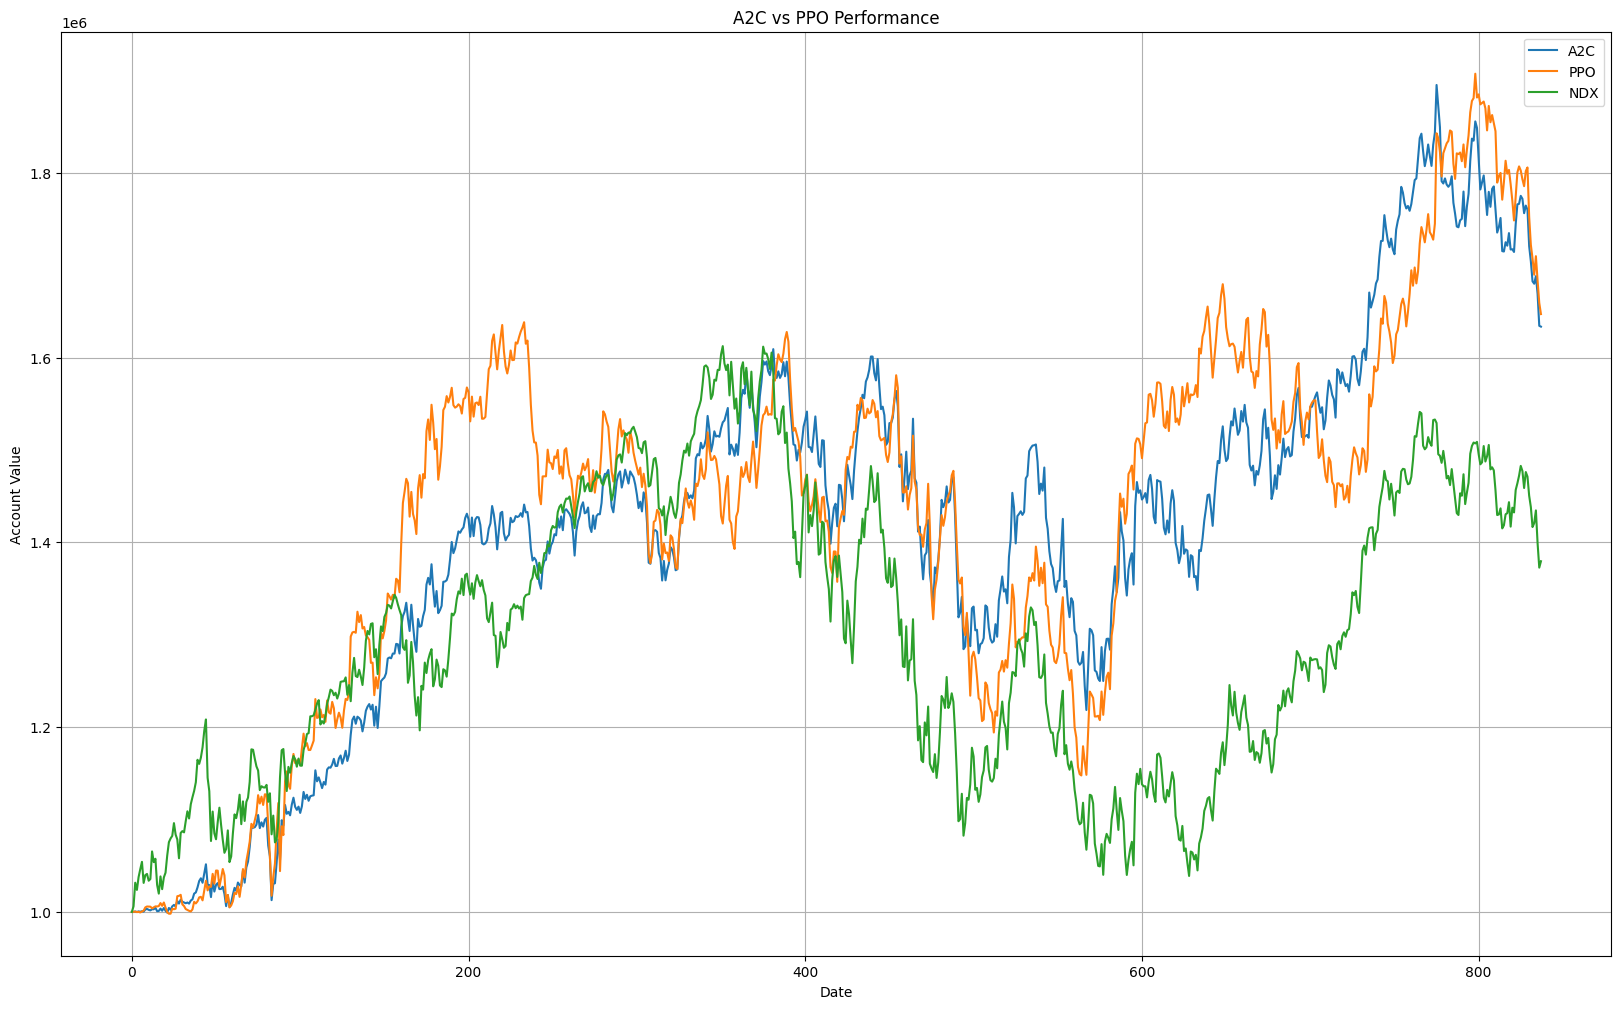

In [156]:
# BEFORE TUNING AND AFTER TUNING

import matplotlib.pyplot as plt
%matplotlib inline

# Plotting code

plt.figure(figsize=(20, 12))
plt.plot(df_account_value_a2c.index, df_account_value_a2c['account_value'], label='A2C')
# plt.plot(df_account_value_ddpg.index, df_account_value_ddpg['account_value'], label='DDPG')
plt.plot(df_account_value_ppo.index, df_account_value_ppo['account_value'], label='PPO')
plt.plot(df_ndx.index, df_ndx['account_value'], label='NDX')

plt.title('A2C vs PPO Performance')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()

# Add grid lines
plt.grid(True)

plt.show()
